# Analysis of Rhythmic Spiking in the Subthalamic Nucleus During a Movement Task

## Introduction

### Background

The subthalamic nucleus (STN) is a component of the basal ganglia that is thought to play an important role in the regulation of motor function. Neurons in the STN often have rhythmic spiking dynamics, and aberrations in the spike rhythms in STN have been associated with tremor and other motor symptoms in Parkinson’s disease. In fact, the STN is one of the primary targets for deep brain stimulation (DBS) to treat Parkinsonian disorders. While the mechanisms by which DBS works are largely unknown, many researchers have hypothesized that altering rhythmic activity in the STN is an important component. Therefore, it is important to be able to characterize spike rhythms in STN neurons and to know with statistical confidence when these rhythms have changed.

In previous chapters, we developed and used methods to uncover rhythmic dynamics in field recordings. Many of the methods used to characterize rhythms in spiking data will be familiar, like autocorrelation functions and spectral estimators, but will require additional care to interpret. In some cases, rhythmic spiking dynamics can be much more subtle than the rhythms we found previously, and statistical modeling methods will be needed to make powerful inferences from spiking data.

### Case Study Data

A clinical neurosurgeon contacts you to help her analyze spiking data she collects from patients with Parkinson’s disease during surgery to implant DBS electrodes. She is interested in making sure that the electrode is localized properly in the STN, and in studying the role that STN activity plays in movement planning and execution for these patients. She asks each patient to perform a simple hand movement task during the electrode implantation procedure, and records the resulting neural activity.

The data consist of single unit spiking activity from one STN neuron recorded over 50 trials of a hand movement task. In each trial, a patient held a joystick and watched cues appear on a screen. The first cue indicated whether the patient should move the joystick to the left or right. The second cue, the GO cue, indicated the time to start moving the joystick. The dataset contains 2 s of activity for each trial, 1 s before the GO cue and 1 s after. We label the period before the GO cue comes on the planning period, and the period after the GO cue the movement period.

### Goal

It is well known that the spiking activity of some STN neurons in patients with Parkinson’s disease shows rhythmic properties in the beta frequency range, 11–30 Hz [30, 31]. The neurosurgeon hypothesizes that information related to the movement task, such as the planning versus the movement period and whether the movement is to the left or right, will influence this rhythmic spiking activity. Our goal is to characterize the spiking properties, identify whether rhythmic activity is present and statistically significant, and how such activity is influenced by the task variables.

### Tools

We extend some of the tools already developed for studying rhythms and modeling spike trains. Many of the basic visualization tools, such as raster plots, ISI histograms, and autocorrelation functions are useful without modification. We compute spectral estimators for spiking data using the same methods as before, but we have to think carefully about how to interpret the spectrum of a point process. Finally, we extend the GLM methods we previously developed for spike train data to allow us to model history-dependent, non-Poisson spiking processes.]

## Data Analysis

### Visual Inspection

To access the data for this chapter, visit `http://github.com/Mark-Kramer/Case-Studies-Kramer-Eden` and download the file `Ch10-spikes-1.mat`. Let’s start by loading the data into Python:

In [1]:
# Prepare the modules and plot settings
import scipy.io as sio
import matplotlib.pyplot as plt
from matplotlib.pyplot import xlabel, ylabel, plot, show, title
from matplotlib import rcParams
import numpy as np
%matplotlib inline
rcParams['figure.figsize'] = (7,6)

data = sio.loadmat('Ch10-spikes-1.mat')  # Load the EEG data
t = data['t'][0] # Extract the t variable
direction = data['direction'] # Extract the direction variable
train = data['train'] # Extract the train variable

We find three variables:

  * `direction`. A [50 x 1] vector of indicators for the movement direction for each of 50 trials. A value of 0 indicates movement to the left, and a value of 1 indicates movement to the right.
  
  
  * `t`. A [1 x 2000] vector of time stamps in milliseconds indicating the time into the trial. Time 0 indicates the GO cue.
  
  
  * `train`. A [50 x 2000] matrix of spike counts in each trial and time bin. The rows of the matrix correspond to trials, while the columns correspond to time.

<div class = "alert alert-info alert-block">

**Q:** How many trials involve movment to the left? to the right? <br><br>

**A:** To answer this, we must count the number of zeros and ones in direction. The `sum` function provides an efficient method to do so: `sum(direction)` which returns a value of 25. We conclude that half of the 50 trials involve right movement, and half involve left movement.

</div>

Our first goal is to construct a raster plot to visualize the spikes through time for every trial. There are many ways to create this plot in Python. One simple way is to realize that the matrix consists of a collection of zeros and ones as a function of time and trial, corresponding exactly to the information for the raster plot. We can treat this matrix as an image and visualize it using the `imshow` function in Python:

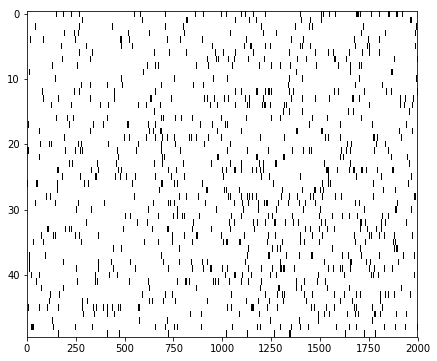

In [2]:
plt.imshow(train, aspect='auto',cmap='gray_r')
plt.show()

Here, we have adjusted the colormap to draw black ticks on a white background for clarity and ease of visual inspection.

Visually, we do not observe much obvious structure in the raster plot. There does not seem to be substantially more spiking either before or after the GO cue. It is also difficult to see any effect of the movement direction for each trial, since left and right trials are interspersed. We can remedy this by grouping all 25 of the left trials together, and all 25 of the right trials together, and generating a new set of raster plots for each trial type.

In [3]:
train.shape

(50, 2000)

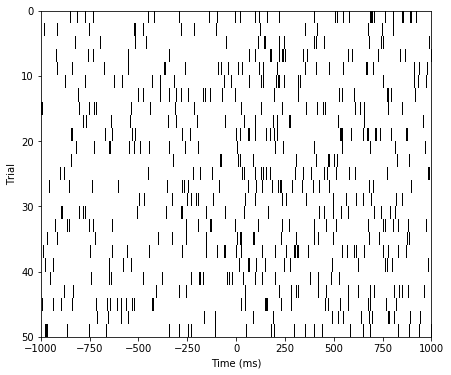

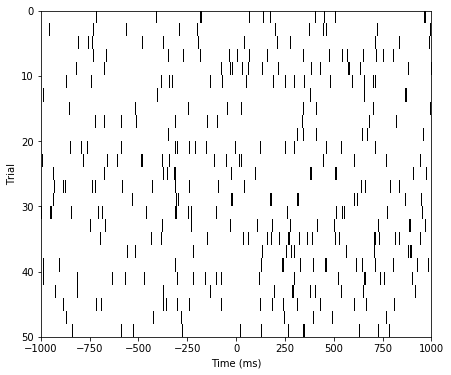

In [4]:
Ltrials = np.where(direction==0)[0]
Rtrials = np.where(direction==1)[0]
plt.imshow(train[Ltrials], aspect = 'auto', cmap='gray_r', extent = (-1000,1000,50,0))
plt.xlabel('Time (ms)')
plt.ylabel('Trial')
plt.show()

plt.imshow(train[Rtrials], aspect = 'auto', cmap='gray_r', extent = (-1000,1000,50,0))
plt.xlabel('Time (ms)')
plt.ylabel('Trial')
plt.show()

<div class='alert alert-info alert-block'>
**Q:** Consider the raster plots for the left and right trials in the above figure. Do you notice any difference in spiking between the two trial types? Is rhythmic spiking apparent?<br><br>
**A:** In the separate raster plots we observe slightly more spiking during left trials than during right trials, both during the planning (before time 0 s) and movement (after time 0 s) periods. However, we do not observe in this raster plot clear evidence of rhythmic spiking. There are places where you might convince yourself that rhythmic spiking is present, but it is not clear whether this structure is real or could occur by chance.
</div>

Often when people think about rhythms in spiking data, they think about spiking occurring almost perfectly regularly at some fixed frequency, like a metronome. However, it is rare to find neural spiking systems with this kind of regularity. Instead, if we think about spiking activity as arising from a random point process, we can consider rhythmic spiking as the influence of past spiking on the probability of observing a spike at some time in the future. In other words, another way to think about rhythmic spiking is as a history-dependent point process. Later, we build specific probability models to capture this history dependence. But first we visualize the other influences in the data, those related to planning and movement, and to direction.

We initially construct a peristimulus time histogram, (PSTH). These PSTHs are useful for visualizing the relation between spike rates and the time relative to a specific time point in repeated trial data. In this case, we look at the spiking rate relative to the time of the GO cue. To compute the PSTH, we partition the time interval into bins, add up the number of spikes that occur within each bin over all trials, and then divide by the number of trials and by the length of the bin. Most often, we select a fixed time width for all the bins.

The matrix train already contains the binned spiking data, where the bins are each 1 ms in duration. If we want to use 1 ms bins for the PSTH, all that needs to be done is to sum over all the trials and scale by the number of trials and bin length.

In [5]:
PSTH = sum(train)/50/1e-3

Here we divide by 50 because we sum the spiking over 50 trials, and we divide by 1e-3 = 0.001 because the bin width is 1 ms = 0.001 s, and we would like to express the rate in units of spikes/s, or Hz. However, this method will only work for 1 ms bins. A more general approach is to find the times of all the spikes and use the hist command to compute the PSTH:

In [6]:
spiketrials, spiketimes = np.where(train)
hist = np.histogram(spiketimes,2000)[0]/50/1e-3

Either method produces the same PSTH result. Now let’s use the bar function to produce a bar graph of the PSTH:

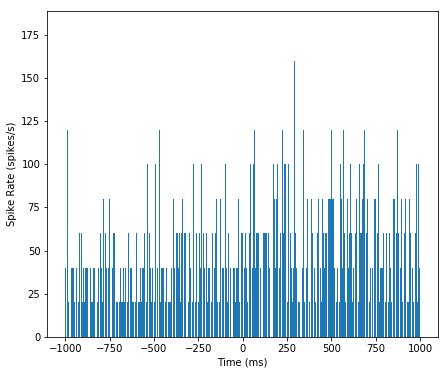

In [7]:
plt.bar(t, hist) 
plt.xlabel('Time (ms)')
plt.ylabel('Spike Rate (spikes/s)')
plt.show()

Although it was not immediately clear from the raster plot, it is evident in the PSTH that there is a difference in the firing rate between planning and movement periods. The firing rate during planning (time < 0 ms) appears to average around 60 spikes/s, and the firing rate during movement (time > 0 ms) appears to be slightly elevated, averaging around 80 spikes/s. However, this PSTH may be a bit misleading because of the very small bin widths used. In each bin, the PSTH only appears to take a few discrete values (e.g., 40, 60, 80 spikes/s) with nothing in between. Also, there are many bins where the PSTH value is equal to zero; these bins are not obvious in the figure because they are masked by nearby bins. The initial PSTH therefore gives a false sense of the average spike rate. To investigate further, let’s increase the PSTH bin width:

<BarContainer object of 200 artists>

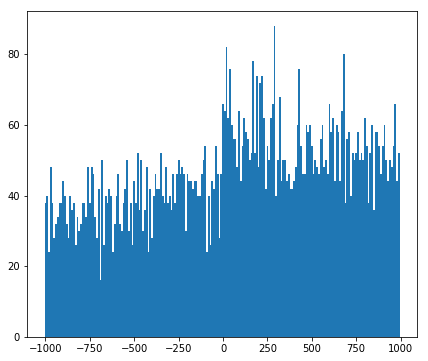

In [8]:
PSTH10 = np.histogram(spiketimes, 200)[0]   #Compute histogram.
plt.figure()
plt.bar(t[np.arange(0, 2000, 10)], PSTH10/50/10*1000,width=10)

<div class='alert alert-info alert-block'>
**Q:** How does the second input to the hist function specify 10 ms bins?
</div>

With 10 ms bin widths, the difference in firing rate between planning and movement periods is still evident, but we see that we had overestimated the firing rate because bins with small PSTH values were masked by neighboring bins with higher values. Now we find that the average firing rate during planning is closer to 35 spikes/s, while the rate during movement is closer to 55 spikes/s.

<div class='alert alert-info alert-block'>
**Q:** Construct a PSTH for these data with 100 ms bins. How does the result compare to the 10 ms bin PSTH in the above figure? What might be some issues that impact PSTHs with large bin widths? What do you think might be a good way to select bin widths for a PSTH?
</div>

We can also compute the average spike rate in the movement and planning periods directly. To do so, we need to average the spiking data over both trials and time in each period.

In [9]:
i_plan = np.where(t < 0)[0]                            #Indices for planning.
i_move = np.where(t >= 0)[0]                           #Indices for movement.
#Compute the average spike rate,
PlanRate = np.mean(np.mean(train[:,i_plan]))/1e-3   #...during planning,
MoveRate = np.mean(np.mean(train[:,i_move]))/1e-3   #...during movement.

<div class='alert alert-info alert-block'>

**Q:** You might notice that we call the function mean twice in this code. What is the effect of these two (nested) function calls?<br><br>

**A:** The variable train is a matrix. The first application of mean computes the mean of each column of train, corresponding to the mean over trials. The result is a (row) vector. The second application of mean operates on this row vector and computes the mean over time to produce a scalar.
</div>

Executing these commands, we find `PlanRate = 38.96`, and `MoveRate = 54.96`. These results are consistent with our estimation of the average firing rates through visual inspection of the histogram with 10ms bins.

In addition to the planning and movement periods, the task can be broken down based on the direction of movement that is cued. The variable direction contains an indicator variable for each trial, which is 0 for left trials and 1 for right trials. Since the left and right trials are interspersed, we need to first find which trials correspond to each direction, and then compute the firing rates for each type of trial. 

In [10]:
Ltrials = np.where(direction==0)[0]       #Find left trials,
Rtrials = np.where(direction==1)[0]           #... and right trials,
LRate = np.mean(np.mean(train[Ltrials,:]))/1e-3 #... and compute rates.
RRate = np.mean(np.mean(train[Rtrials,:]))/1e-3

<div class='alert alert-info alert-block'>
**Q:** What do you conclude about the firing rates for the two types of trials? <br><br>

**A:** Upon executing these commands, we find `LRate = 58.66` and `RRate = 35.26`. These results suggest that the spiking rates for planning and movement in left trials are higher than the rates for right trials.
</div>

We have now shown that the average firing rate changes between planning and movement periods, and between left and right trials. One question that arises is how the changes pertaining to trial period and to trial direction are related. We have four categories to explore: planning for left trials, planning for right trials, movement on left trials, and movement on right trials. We could compute the mean firing rates in each of these categories. Instead, let’s examine the trial-to-trial distribution of firing rates in each category. Let’s sum the spiking over each 1 s planning or movement period for each trial type, and generate a box plot that visualizes these distributions:

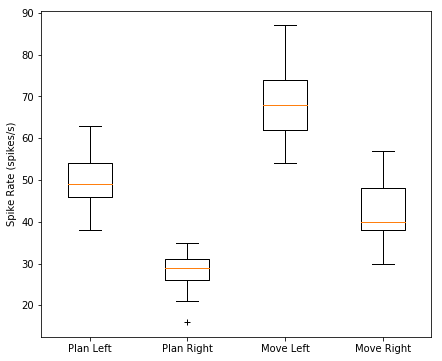

In [11]:
PlanL = np.sum(train[Ltrials][:,i_plan], axis = 1)   # Firing rate L, planning.
PlanR = np.sum(train[Rtrials][:,i_plan], axis = 1)   # Firing rate R, planning.
MoveL = np.sum(train[Ltrials][:,i_move], axis = 1)   # Firing rate L, movement.
MoveR = np.sum(train[Rtrials][:,i_move], axis = 1)   # Firing rate R, movement.
plt.figure()
plt.boxplot([PlanL, PlanR, MoveL, MoveR], sym='+', labels = ['Plan Left', 'Plan Right', 'Move Left', 'Move Right'])
plt.ylabel('Spike Rate (spikes/s)')
plt.show()


<div class='alert alert-info alert-block'>
**Q:** Have you used the function boxplot before? If not, look it up in Matplotlib Help.
</div>

<div class='alert alert-info alert-block'>
**Q:** How do the variables in this code correspond to firing rates?<br><br>

**A:** In this case, the duration of the interval is 1 s for both planning and movement periods. Therefore, we may think of dividing each sum by 1 s, which does not affect the numerical values in the variables.
</div>

The box plot corroborates our previous findings that the firing rate is increased in left trials and in the movement period of each trial. Further, it suggests that these effects may occur independently and additively; the difference between left and right trials seems approximately the same for both planning and movement periods. At this stage, it would be natural to ask whether these differences between mean firing rates are statistically significant. We explore issues of significance later, and discuss why some traditional approaches for comparing means across groups (such as *t*-tests between pairs or analysis of variance between all groups) might not capture the structure in the data very well.

While these visualizations have helped elucidate the long-term spiking structure over periods of about 1 s, they have not provided much information about short-term rhythmic structure. In chapter 8, we used interspike interval (ISI) histograms to help visualize fine time scale history dependence in spiking activity. Let’s do so again here. To compute the ISI histogram, we first need to compute the ISIs. One approach is to write a for-loop that iterates through each trial in the `train` matrix, finds the spike times, and computes the ISIs. However, in constructing the PSTH, we computed the variable `spiketimes`, which already contains the spike times in trial 1, followed by the spike times in trial 2, and so on, all in one array. If we compute the differences in these spike times, we will have the ISIs for each trial mixed with an occasional negative value when an element of spiketimes is the first spike time for any trial. Let’s eliminate these spurious values and plot a histogram of the ISIs:

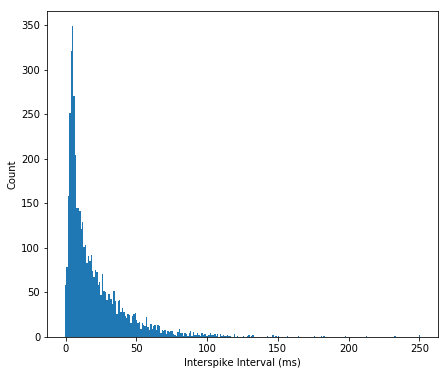

In [12]:
ISIs=np.diff(spiketimes)
ISIs = ISIs[np.where(ISIs>0)]
hist = np.histogram(ISIs, 250)[0]

plt.figure()
plt.bar(np.linspace(0, 250, 250), hist, width = 1)
plt.xlabel('Interspike Interval (ms)')
plt.ylabel('Count')
plt.show()


<div class='alert alert-info alert-block'>
**Q:** Can you think of a way this code might lead to incorrect computation of the ISIs? Did this happen for this dataset?<br><br>

**A:** If the last spike in any given trial occurred at an earlier time than the first spike in the subsequent trial, then the ISI computed between trials would not be negative and would not be removed. This never happens in these data, but it suggests that we should be careful when we code various procedures to think about the possible outcomes.
</div>

The ISI histogram in the above figure reveals a few interesting features, including a short relative refractory period (fewer ISIs near 0 ms) and a large number of ISIs near about 6 ms, suggesting bursting activity (i.e., times of rapid spiking with small intervals between spikes). However, it is difficult to see any structure that looks like clear rhythmic spiking, such as a large second peak at longer ISIs. Let’s see if there is a difference in the ISI distributions for planning and movement periods:

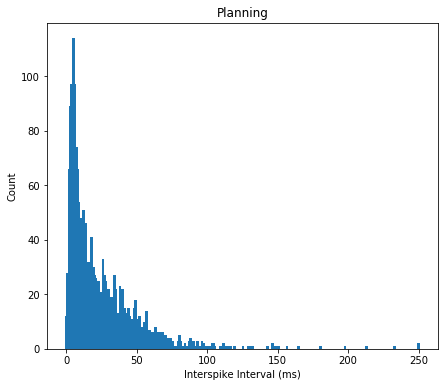

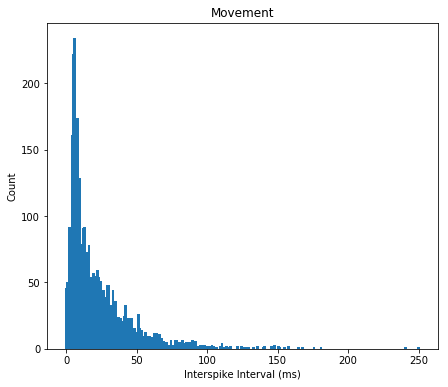

In [13]:
#In the planning period,       
spiketrialsPlan, spiketimesPlan = np.where(train[:,i_plan]>0) # find spikes
PlanISIs = np.diff(spiketimesPlan)                            # compute ISIs,
PlanISIs = PlanISIs[np.where(PlanISIs>0)]                     # drop spurious ones,
planhist = np.histogram(PlanISIs, 250)[0]

plt.figure()
plt.bar(np.linspace(0, 250, 250), planhist, width = 2)            # plot ISIs
plt.xlabel('Interspike Interval (ms)')                        # label axes
plt.ylabel('Count')
plt.title('Planning')
plt.show()

#In the movement period,       
spiketrialsMove, spiketimesMove = np.where(train[:,i_move]>0) # find spikes
MoveISIs = np.diff(spiketimesMove)                            # compute ISIs,
MoveISIs = MoveISIs[np.where(MoveISIs>0)]                     # drop spurious ones,
movehist = np.histogram(MoveISIs, 250)[0]

plt.figure()
plt.bar(np.linspace(0, 250, 250), movehist, width = 2)            # plot ISIs
plt.xlabel('Interspike Interval (ms)')                        # label axes
plt.ylabel('Count')
plt.title('Movement')
plt.show()

<div class="alert alert-info alert-block">
**Q:** What features differ between the ISI histograms for the planning and movement periods, shown above?<br><br>

**A:** There are a few notable differences between the ISI histograms in the two periods. The total number of ISIs is larger during the movement period, corroborating our earlier finding that the firing rate is higher during this period. The peak in the ISI distribution around 6 ms seems more pronounced during movement, suggesting a higher tendency to fire in bursts. There may be some differences in the tail structure of the ISI distribution at ISI values above 20 ms, but it is difficult to relate this to differences in rhythmic spiking structure.
</div>

In chapter 8, we also used the sample autocorrelation function (ACF) to visualize history-dependent spiking properties. Recall that the ACF shows the correlation between a signal at two points in time separated by a fixed lag, evaluated over different values of the lag. For these spike train data, let’s use the increments (i.e., the number of spikes in each time bin) as the signal, compute the ACF for each trial, and average the results over all the trials.

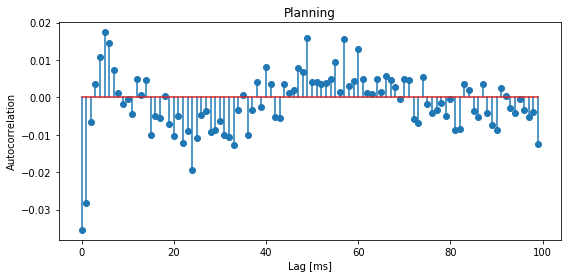

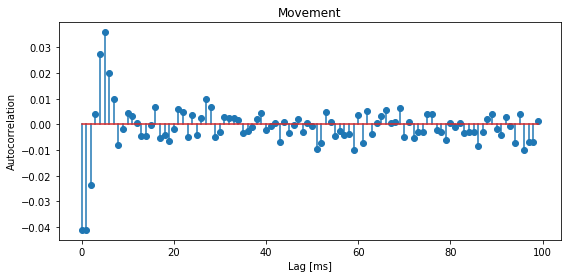

In [49]:
rcParams['figure.figsize'] = (9,4)
acf1 = np.zeros((50,1999))
acf2 = np.zeros((50, 1999))

for k in range(50):
    plan = train[k, i_plan]  # get planning data,
    move = train[k, i_move]  # get movement data,
    corr1 = np.correlate(plan - np.mean(plan), plan - np.mean(plan), 'full')
    acf1[k] = corr1 / np.linalg.norm(plan - np.mean(plan))**2                    #Normalize autocorrelation
    corr2 = np.correlate(move - np.mean(move), move - np.mean(move), 'full')
    acf2[k] = corr2 / np.linalg.norm(move - np.mean(move))**2                    #Normalize autocorrelation
    
plt.figure()
plt.stem(np.mean(acf1[:,1000:1100], axis = 0))
plt.xlabel('Lag [ms]')
plt.ylabel('Autocorrelation')
plt.title('Planning')
plt.show()

plt.figure()
plt.stem(np.mean(acf2[:,1000:1100], axis = 0))
plt.xlabel('Lag [ms]')
plt.ylabel('Autocorrelation')
plt.title('Movement')
plt.show()

<div class='alert alert-info alert-block'>
**Q:** Why do we examine the variables acf1 and acf2 at columns 1000:1100? <br><br>

**A:** The columns of both matrices specify the lags, which extend from  1 s to +1 s. We choose indices 1000:1100 to investigate positive lags beginning at 1 ms and ending at 100 ms. Notice that we compute the mean of both matrices across trials (rows) before displaying the results.
</div>

The autocorrelation plots for both the planning and movement periods show very clear structure. In both periods we see negative correlation for lags of 1–3 ms, followed by positive correlation at lags of 1–8 ms, with a peak at a lag of 6 ms. During the planning period, we see clear structure continuing at higher lags, with an extended period of negative correlations at lags of about 15–35 ms and positive correlations at lags of about 50–70 ms. For the movement period, this structure at lags longer than about 10 ms seems reduced or even absent. These results suggest a change in the rhythmic firing properties between the planning and movement periods. The second peak in the autocorrelation plot for the planning period around 60 ms suggests a 1/60 ms $\approx$17 Hz rhythm that disappears during movement.

### Spectral Analysis of Spiking Data

So far, we have focused on statistical characterizations of spike trains in the time domain. Another approach to visualizing and describing structure in point processes focuses on estimating rhythmic (or harmonic) features of the data in the frequency domain. In chap- ters 3 and 4, we discussed methods to decompose field data (or continuous valued functions and random processes) into harmonic components. The same type of approach can be used to decompose point processes and to determine the relative contributions to their variability attributable to each frequency. Point process spectral estimation provides a useful tool for spike train analysis but should be performed with care. On the one hand, computing spectral estimates for discrete spike train data is similar to the approaches used for continuous valued signals. On the other hand, the interpretation of point process spectra can differ from continuous process spectra, and blindly applying intuition from continuous spectral estimation to point process data can lead to incorrect interpretations.

#### Point Process Spectral Theory. 

In this section, we develop some of the theory needed to understand and interpret spectral estimators for spiking data. As with the spectrum for continuous valued processes (chapter 3), the spectrum for a point process can be expressed as the Fourier transform of its autocovariance function. In discrete time, assume we have binned the spiking activity into intervals of length $\Delta t$, and that $\Delta N_i$ represents the number of spikes fired in the $i^{th}$ interval, which is called the $i^{th}$ increment. The autocovariance sequence is then

\begin{align}
\gamma(h) &=E[(\Delta N_i - \lambda_0\Delta t)( \Delta N_{i+h} - \lambda_0\Delta t)]\\
&=E[\Delta N_i \Delta N_{i + h}] - (\lambda_0 \Delta t)^2
\end{align}

where  $\lambda_0 \Delta t$ is the expected number of spikes in a single time bin. The discrete spectrum is the discrete Fourier transform of this sequence. Using this definition, we can compute the theoretical autocovariance and spectrum for any stationary point process model.

**Example 1: Spectral density of a homogeneous Poisson process.** For a homogeneous Poisson process, the increments $\Delta N_i$ are independent, and each has a Poisson distribution with the same mean. Assume the mean number of spikes in any bin is  $\lambda_0 \Delta t$. Since the mean and variance of a Poisson random variable are the same (see chapter 8 appendix), this is also the variance of any increment. The autocovariance at a lag $h = 0$ is just the variance of $\Delta N_i$, which is  $\lambda_0 \Delta t$. At any other lag, the increments are independent and therefore the autocovariance is zero. The autocovariance function is given by